In [13]:
import sys

sys.path.append("./../../src")


from Dataset import SpeechCommandsDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from Transformer import plot_confusion_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
test_dataset = SpeechCommandsDataset("./../../data/test", mode="modified")
train_dataset = SpeechCommandsDataset("./../../data/train", mode="modified")

In [15]:
class SpeechCommandGRU(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, num_layers=2, num_classes=35):
        super(SpeechCommandGRU, self).__init__()

        # Apply a 1D Conv to reduce dimensionality and extract features
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=80, stride=40),  # (16000 -> 400)
            nn.ReLU(),
            nn.Conv1d(32, input_size, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.squeeze(1)
        x = x.unsqueeze(1)  # (batch, 1, 16000)
        x = self.conv(x)  # (batch, input_size, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, input_size)
        out, _ = self.rnn(x)  # (batch, time_steps, hidden_size*2)
        out = out[:, -1, :]  # Use last timestep
        out = self.fc(out)  # (batch, num_classes)
        return out

In [16]:
def evaluate(model, dataloader, device, silent=False):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)

            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    if not silent:
        print(f"Test Accuracy: {accuracy:.2%}, Avg Loss: {avg_loss:.4f}")
    return accuracy, avg_loss

In [17]:
def plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue")
    plt.plot(epochs, test_losses, label="Test Accuracy", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [18]:
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SpeechCommandGRU(num_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 63.30% | Test Acc: 62.94%
Epoch 2 | Train Acc: 69.53% | Test Acc: 77.68%
Epoch 3 | Train Acc: 82.43% | Test Acc: 84.13%
Epoch 4 | Train Acc: 86.80% | Test Acc: 86.97%
Epoch 5 | Train Acc: 89.25% | Test Acc: 88.59%
Epoch 6 | Train Acc: 91.03% | Test Acc: 89.17%
Epoch 7 | Train Acc: 92.37% | Test Acc: 91.81%
Epoch 8 | Train Acc: 93.41% | Test Acc: 91.99%
Epoch 9 | Train Acc: 94.37% | Test Acc: 92.05%
Epoch 10 | Train Acc: 94.85% | Test Acc: 91.95%
Epoch 11 | Train Acc: 95.24% | Test Acc: 92.42%
Epoch 12 | Train Acc: 95.63% | Test Acc: 93.51%
Epoch 13 | Train Acc: 96.07% | Test Acc: 93.27%
Epoch 14 | Train Acc: 96.29% | Test Acc: 93.44%
Epoch 15 | Train Acc: 96.48% | Test Acc: 93.21%
Epoch 16 | Train Acc: 96.75% | Test Acc: 93.93%
Epoch 17 | Train Acc: 91.97% | Test Acc: 85.79%
Epoch 18 | Train Acc: 89.43% | Test Acc: 89.82%
Epoch 19 | Train Acc: 92.78% | Test Acc: 90.70%
Epoch 20 | Train Acc: 94.36% | Test Acc: 92.01%
Epoch 21 | Train Acc: 94.91% | Test Acc: 88.65%
E

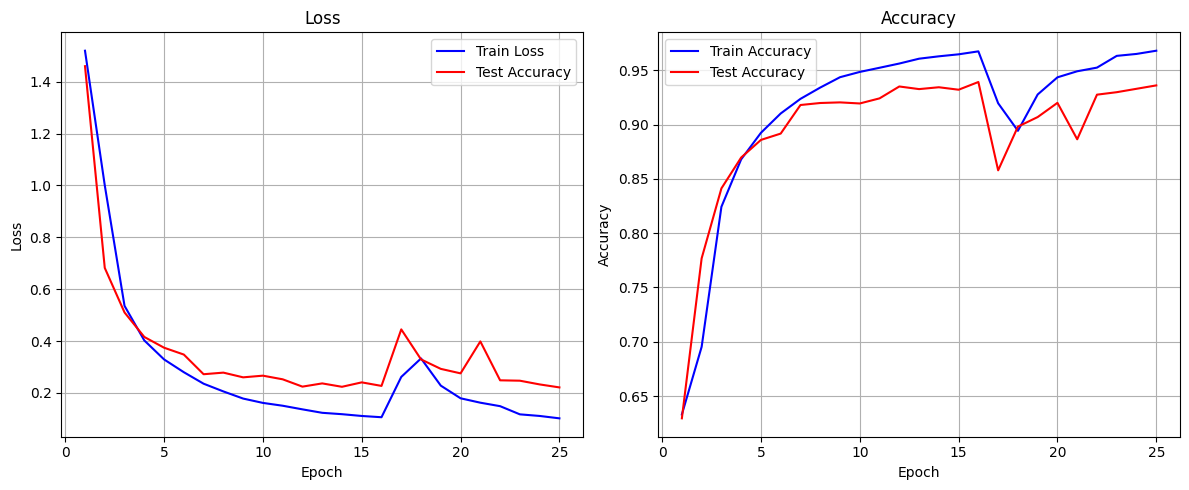

In [20]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

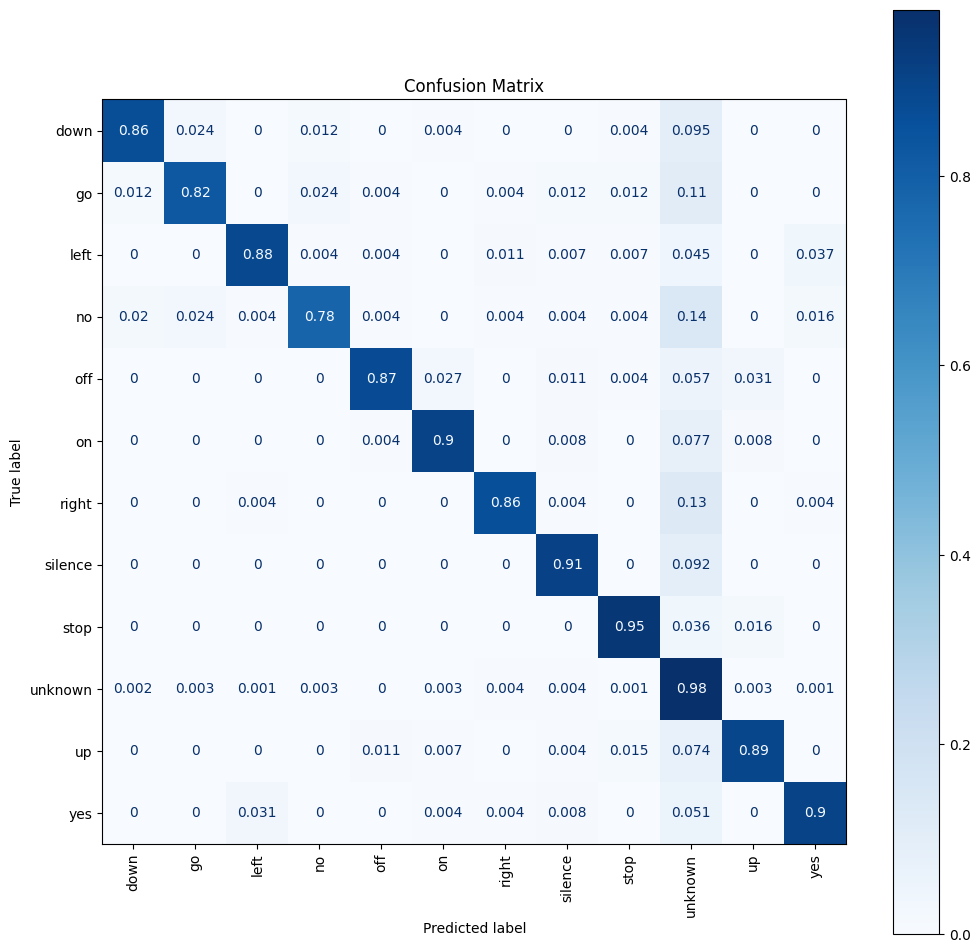

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [21]:
true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SpeechCommandGRU(num_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 63.20% | Test Acc: 62.99%
Epoch 2 | Train Acc: 69.22% | Test Acc: 77.80%
Epoch 3 | Train Acc: 82.50% | Test Acc: 83.61%
Epoch 4 | Train Acc: 87.31% | Test Acc: 87.40%
Epoch 5 | Train Acc: 90.64% | Test Acc: 88.59%
Epoch 6 | Train Acc: 92.57% | Test Acc: 91.35%
Epoch 7 | Train Acc: 93.66% | Test Acc: 92.22%
Epoch 8 | Train Acc: 94.35% | Test Acc: 92.49%
Epoch 9 | Train Acc: 94.89% | Test Acc: 92.50%
Epoch 10 | Train Acc: 95.23% | Test Acc: 92.97%
Epoch 11 | Train Acc: 95.54% | Test Acc: 93.39%
Epoch 12 | Train Acc: 95.92% | Test Acc: 93.47%
Epoch 13 | Train Acc: 96.21% | Test Acc: 93.43%
Epoch 14 | Train Acc: 96.32% | Test Acc: 93.41%
Epoch 15 | Train Acc: 96.71% | Test Acc: 93.91%
Epoch 16 | Train Acc: 96.93% | Test Acc: 93.98%
Epoch 17 | Train Acc: 93.72% | Test Acc: 89.27%
Epoch 18 | Train Acc: 94.28% | Test Acc: 93.04%
Epoch 19 | Train Acc: 96.65% | Test Acc: 94.22%
Epoch 20 | Train Acc: 97.10% | Test Acc: 94.15%


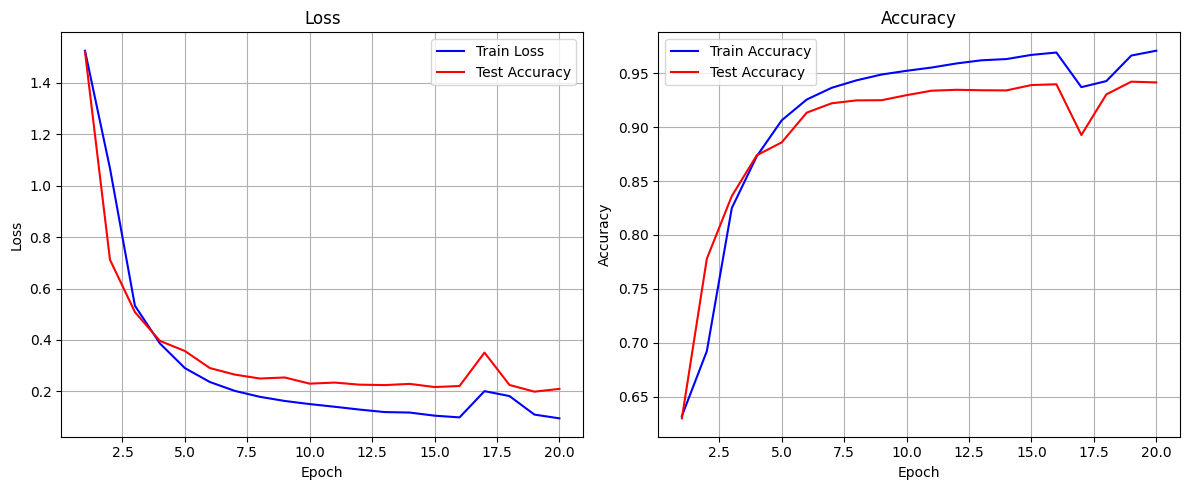

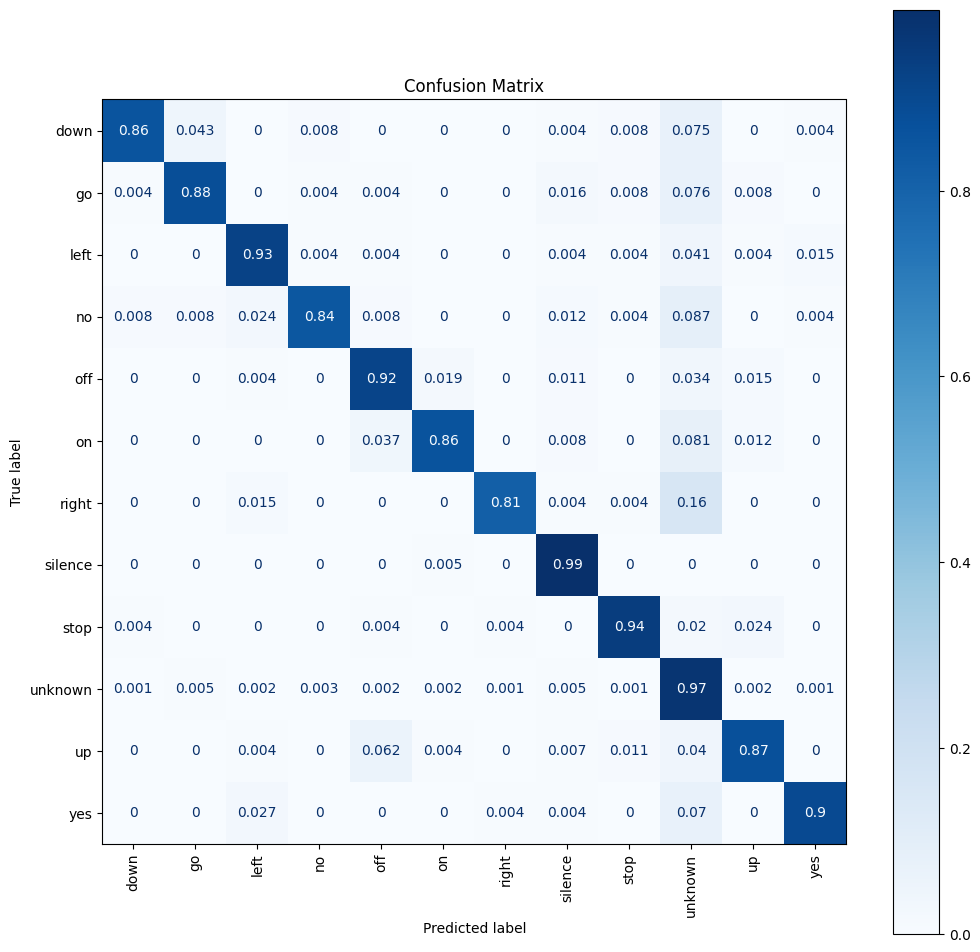

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [23]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)

In [24]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SpeechCommandGRU(num_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 63.00% | Test Acc: 61.25%
Epoch 2 | Train Acc: 63.40% | Test Acc: 61.96%
Epoch 3 | Train Acc: 71.34% | Test Acc: 77.27%
Epoch 4 | Train Acc: 81.37% | Test Acc: 83.80%
Epoch 5 | Train Acc: 86.60% | Test Acc: 86.84%
Epoch 6 | Train Acc: 89.76% | Test Acc: 88.90%
Epoch 7 | Train Acc: 91.61% | Test Acc: 90.54%
Epoch 8 | Train Acc: 92.78% | Test Acc: 91.31%
Epoch 9 | Train Acc: 93.71% | Test Acc: 90.87%
Epoch 10 | Train Acc: 93.97% | Test Acc: 91.98%
Epoch 11 | Train Acc: 94.71% | Test Acc: 91.79%
Epoch 12 | Train Acc: 95.22% | Test Acc: 91.51%
Epoch 13 | Train Acc: 95.53% | Test Acc: 92.52%
Epoch 14 | Train Acc: 95.81% | Test Acc: 92.05%
Epoch 15 | Train Acc: 96.19% | Test Acc: 92.72%
Epoch 16 | Train Acc: 96.41% | Test Acc: 92.48%
Epoch 17 | Train Acc: 96.56% | Test Acc: 92.35%
Epoch 18 | Train Acc: 96.75% | Test Acc: 93.03%
Epoch 19 | Train Acc: 97.02% | Test Acc: 92.73%
Epoch 20 | Train Acc: 97.06% | Test Acc: 93.36%


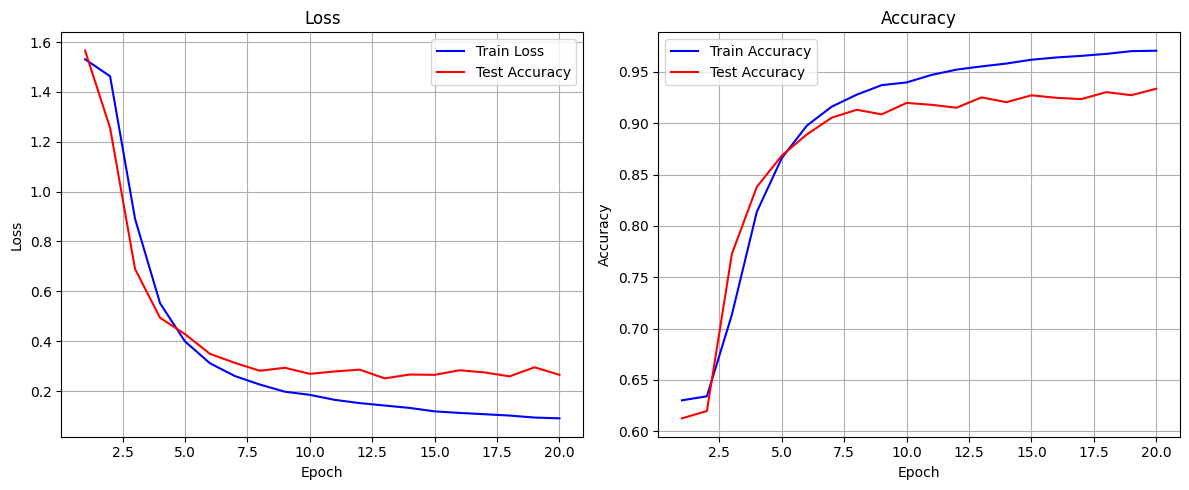

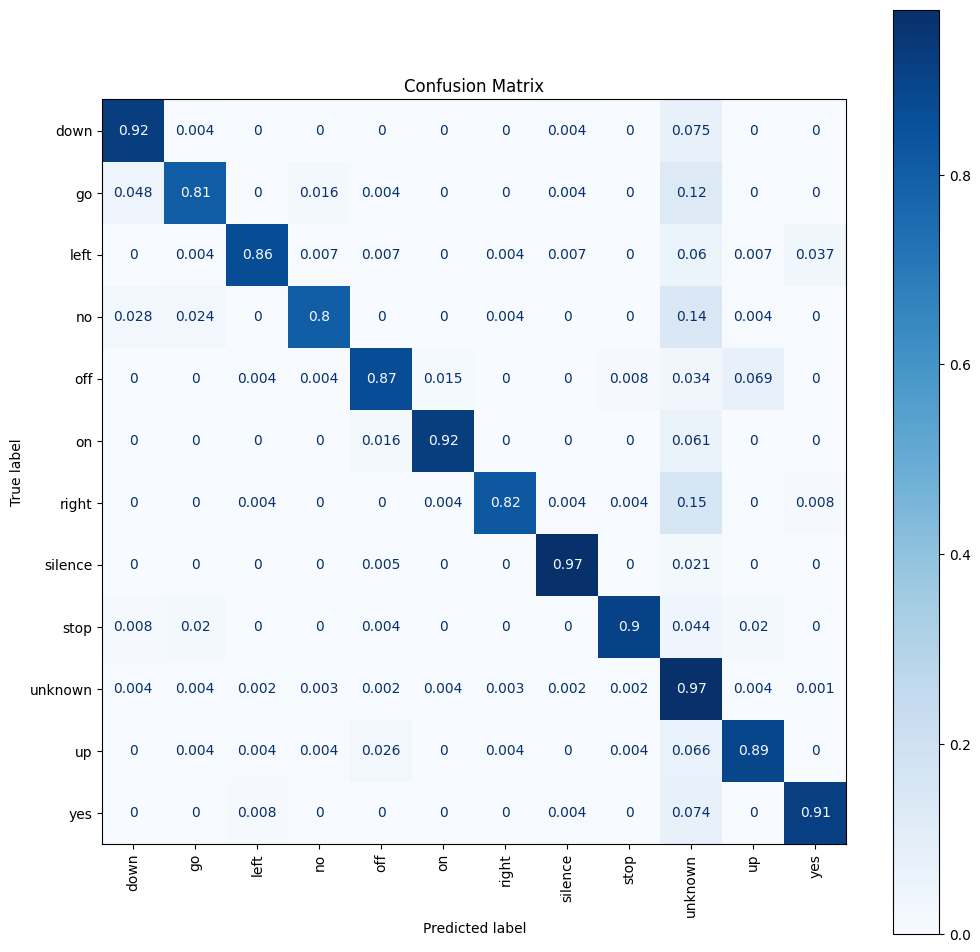

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [25]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)

In [26]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SpeechCommandGRU(num_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

num_epochs = 30

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 62.99% | Test Acc: 61.93%
Epoch 2 | Train Acc: 63.88% | Test Acc: 64.82%
Epoch 3 | Train Acc: 70.14% | Test Acc: 76.03%
Epoch 4 | Train Acc: 80.52% | Test Acc: 81.91%
Epoch 5 | Train Acc: 85.72% | Test Acc: 86.70%
Epoch 6 | Train Acc: 89.50% | Test Acc: 89.12%
Epoch 7 | Train Acc: 91.85% | Test Acc: 90.06%
Epoch 8 | Train Acc: 92.99% | Test Acc: 92.19%
Epoch 9 | Train Acc: 93.96% | Test Acc: 92.96%
Epoch 10 | Train Acc: 94.45% | Test Acc: 92.35%
Epoch 11 | Train Acc: 95.04% | Test Acc: 92.99%
Epoch 12 | Train Acc: 95.48% | Test Acc: 92.69%
Epoch 13 | Train Acc: 95.80% | Test Acc: 93.31%
Epoch 14 | Train Acc: 96.26% | Test Acc: 93.60%
Epoch 15 | Train Acc: 96.44% | Test Acc: 93.04%
Epoch 16 | Train Acc: 96.61% | Test Acc: 93.58%
Epoch 17 | Train Acc: 96.75% | Test Acc: 93.26%
Epoch 18 | Train Acc: 97.03% | Test Acc: 93.43%
Epoch 19 | Train Acc: 97.25% | Test Acc: 93.12%
Epoch 20 | Train Acc: 97.28% | Test Acc: 93.40%
Epoch 21 | Train Acc: 97.18% | Test Acc: 93.81%
E

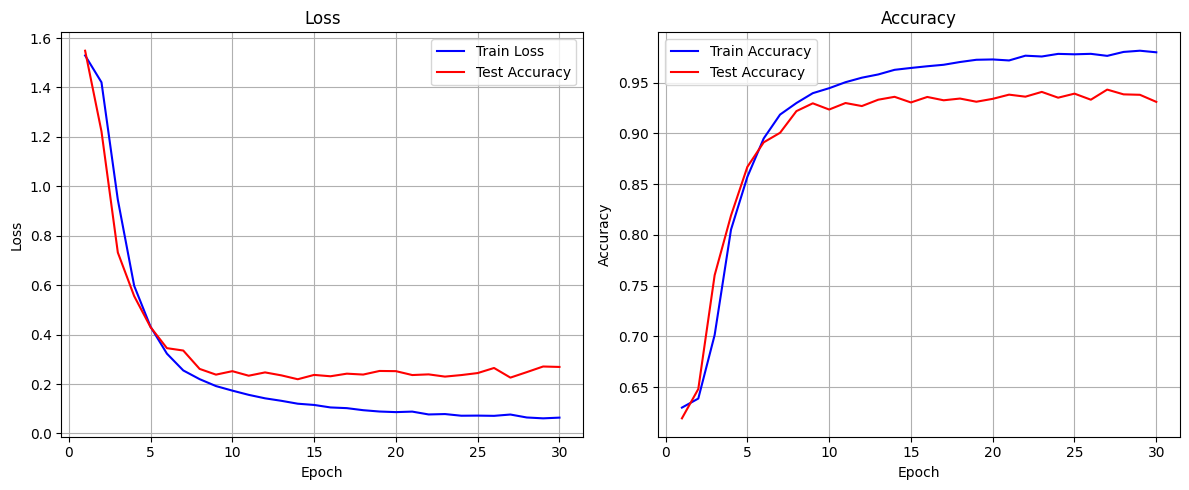

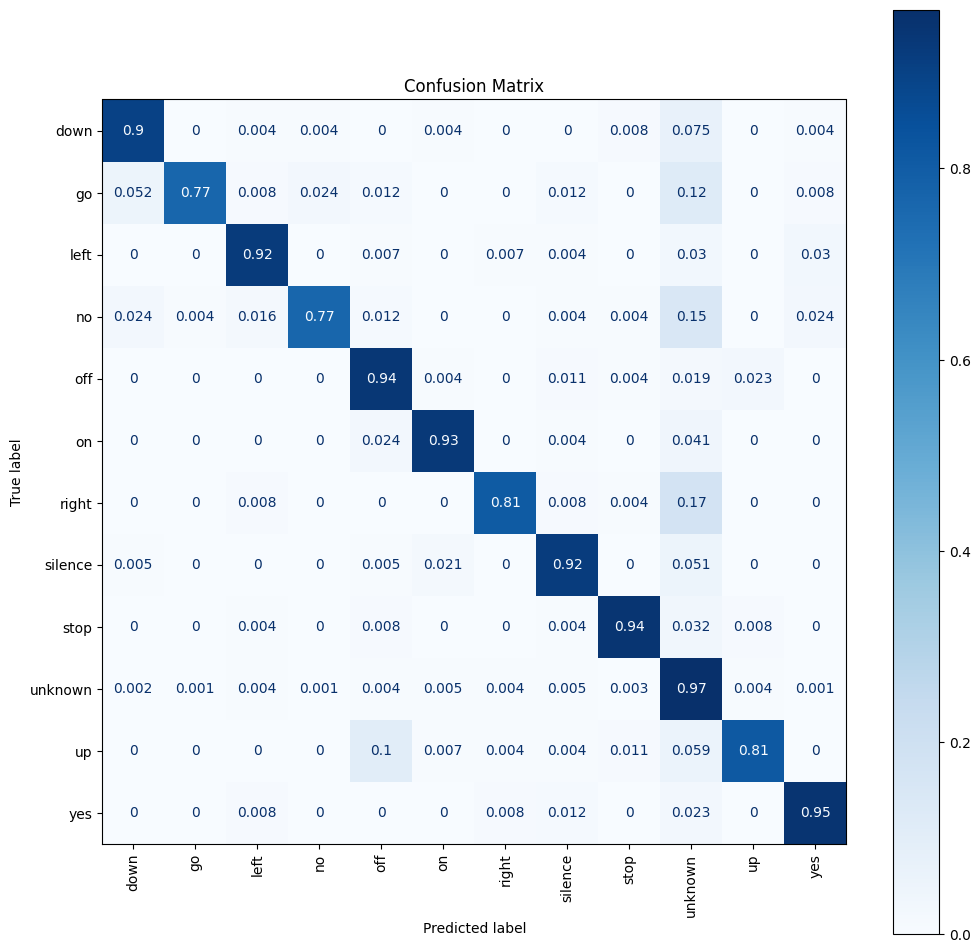

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [27]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)